# 3rd practice: Neural Networks
* **Course**: Artificial Intelligence
* **University**: Universitat Rovira i Virgili

In this practice students will explore the following fundamentals of machine learning:
* Data analysis
* Preprocessing
* Basic desgin of Multi-Layer Perceptrons (MLP)
* Training of neural networks
* Results analysis
* Decision making / Critical thinking

While reading this notebook, please note the following information:
* Each section (and subsection) has a title and a brief description of its contents.
* If a section (or subsection) title begins with `Student` and/or is **<font color='orange'>written in orange</font>**, the student has work to do inside it, adding code and/or text.
* If the title of a section begins with `Teacher`, all its content (including subsections) is part of the work statement. Subsequently, it **MUST NOT** be modified.
* Sections must be executed in order.
* The addition of imports is not allowed. Everything must be solved with the ones done in `Teacher: Initialization`.
* **<font color='orange'>Please enter your full names in the next cell in this section and run it BEFORE going any further.</font>**

The practice is designed to be done in **Google Colab**. You can find multiple tutorials on Google Colab and Pandas in Moodle.

The dataset to be used (**available on Moodle**) was extracted from [this website](https://www.kaggle.com/datasets/mfarhaannazirkhan/heart-dataset). **The task is to predict the `sex` attribute using all other attributes (except `target`) as inputs.** The `target` attribute cannot be used in any case, neither as input nor as ground truth.


## Deliverable
It is a practice **in pairs**. The students only need to deliver **this notebook** including the answers. The file must have as name `P3_[NameSurnames1]-[NameSurnames2].ipynb`, replacing `[NameSurnames1]` and `[NameSurnames2]` with those from the students.

## Evaluation
To be accepted, all practices delivered must contain **the two solutions with different preprocessing steps** and **the solution with a non-basic MLP**.

**All text must be written in English.**

<font color='red'>**Similar or identical practices will get a grade of 0.**</font>

In [2]:
STUDENT_NAMES = "FULL NAMES OF BOTH STUDENTS HERE" # @param {type:"string"}

# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [3]:
import pandas as pd
import numpy as np
from hashlib import sha256

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for faster training (and prediction).

In [4]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is GPU available. Printing GPU information:
Wed May 14 11:30:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   35C    P8             12W /  320W |     819MiB /  16376MiB |      1%      Default |
|                                         |                        |                  N/A 

# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
The `data_loading` function loads a `.csv` file (such as that available on Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 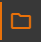. If you use a web browser *other* than Google Chrome, the loading may fail (e.g., the loading circle is red and never ends). To be used in the [Exploratory data analysis](#data_analysis) section.

The dataframe to be used in practice is a pseudo-random subset of the full dataset, **different from that of other students**.

In [5]:
LABEL_COL_NAME = "sex" # Global constant


def data_loading(file_name:str):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["target"]) # Remove some columns that CANNOT be used # TODO

  # Manage the unbalance of the LABEL_COL
  original_df = balance_df(original_df, LABEL_COL_NAME, 1.8)

  # Renaming of number-coded categories to category name
  mapping = {"sex": {"0":"Female", "1":"Male"},
             "cp": {"0":"Typical angina", "1":"Atypical angina", "2":"Non-anginal pain", "3":"Asymptomatic", "4":"Unknown"},
             "fbs":{"0":"<=120mg/dl", "1":">120mg/dl"},
             "restecg":{"0":"Normal", "1":"ST-T wave abnormality", "2":"Left ventricular hypertrophy"},
             "exang":{"0":"Yes", "1":"No"},
             "slope":{"0":"Upsloping", "1":"Flat", "2":"Downsloping", "3":"Unknown"},
             "thal":{"0":"Normal", "1":"Fixed defect", "2":"Reversible defect", "3":"Type 3", "6":"Type 6", "7":"Type 7"}}
  for col_name, maps in mapping.items():
    original_df[col_name] = original_df[col_name].astype(str)
    for old_value, new_value in maps.items():
        original_df.loc[original_df[col_name] == old_value, col_name] = new_value

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac = 1/3
  names_hash = int.from_bytes(bytearray(sha256(STUDENT_NAMES.encode('utf-8')).digest()), byteorder='big')
  random_seed = names_hash % (2**32-1) # Seed must be between 0 and 2**32 - 1
  student_df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  student_df = student_df.drop(columns=["index"])

  return student_df


def balance_df(df:pd.DataFrame, label_col_name:str, ratio:float) -> pd.DataFrame:
    # Count the occurrences of each value in the column
    value_counts = df[label_col_name].value_counts()
    
    # Identify the majority and minority classes
    majority_class = value_counts.idxmax()
    minority_class = value_counts.idxmin()
    
    majority_count = value_counts[majority_class]
    minority_count = value_counts[minority_class]

    # Determine how many rows to drop
    target_majority_count = int(ratio*minority_count)
    excess_majority_count = max(0, majority_count - target_majority_count)
    
    # Retain only the first rows of the majority class
    balanced_df = df.copy()
    balanced_majority = balanced_df[balanced_df[label_col_name] == majority_class].iloc[:target_majority_count]
    balanced_rest = balanced_df[balanced_df[label_col_name] != majority_class]

    # Concatenate to get the final balanced DataFrame
    balanced_df = pd.concat([balanced_majority, balanced_rest]).reset_index(drop=True)

    return balanced_df

## Analysis
Functions that facilitate the data distribution analysis. The functions receive the Panda's dataframe and the name of the column (or columns) to consider. To be used in the [Exploratory data analysis](#data_analysis) section.

In [6]:
def feature_histogram(df:pd.DataFrame, column_name:str):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()


def feature_stats(df:pd.DataFrame, column_name:str, verbose:bool=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  else:
    stats["Unique"] = column_data.value_counts()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats


def features_relationship(df:pd.DataFrame, column_name_1:str, column_name_2:str): 
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.hexbin(data1, data2, gridsize=30, cmap='Blues', mincnt=1) # Use hexbin for visibility of overlaps
        plt.colorbar(label='Count')
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif not pd.api.types.is_numeric_dtype(data1) and not pd.api.types.is_numeric_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_numeric_dtype(data1):
            categorical_column = column_name_2
            numerical_column = column_name_1
        else:
            categorical_column = column_name_1
            numerical_column = column_name_2
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=categorical_column, y=numerical_column, data=df)
        plt.title(f'Relationship between {categorical_column} and {numerical_column}')
        plt.xticks(rotation=45)
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed Pandas' dataframe into the training and test datasets, both using the PyTorch's TensorDataset class. To be used in the [Experiments](#experiments) section.

In [7]:
def df_to_dataset(preprocessed_df:pd.DataFrame, label_col_name:str=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe MUST contain the label column [{label_col_name}], preferably in the last column.")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split: 80% train, 20% test
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional information for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model **instanciation** and allocation in **DEVICE** (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [8]:
def create_model(model_class, input_size:int, num_classes:int, verbose:bool=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [9]:
def train(model:nn.Module, train_dataset:Dataset, test_dataset:Dataset, num_epochs:int, lr:float):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloaders with hard-coded batch size
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Set up loss evolution plot
    train_losses = []
    test_losses = []

    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Loss Evolution')

    train_line, = ax.plot([], [], label='Training Loss', color='blue')
    test_line, = ax.plot([], [], label='Test Loss', color='orange')
    ax.legend()

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation phase
        mean_train_loss = loss_of_dataloader(model, train_loader, criterion)
        train_losses.append(mean_train_loss)
        mean_test_loss = loss_of_dataloader(model, test_loader, criterion)
        test_losses.append(mean_test_loss)

        # Update plot
        train_line.set_ydata(train_losses)
        train_line.set_xdata(range(1, len(train_losses) + 1))

        test_line.set_ydata(test_losses)
        test_line.set_xdata(range(1, len(test_losses) + 1))

        ax.relim()
        ax.autoscale_view()

        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Training Loss: {mean_train_loss:.4f} (starting at {train_losses[0]:.4f}) | Test Loss: {mean_test_loss:.4f} (starting at {test_losses[0]:.4f})')

    # Turn off interactive mode
    plt.ioff()
    plt.close()

    return train_losses, test_losses

def loss_of_dataloader(model:nn.Module, dataloader:DataLoader, criterion):
    total_loss = 0.0
    num_samples = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * len(inputs) # Avg. loss * #samples
            num_samples += len(inputs)
    model.train()

    mean_loss = total_loss / num_samples

    return mean_loss


## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the evaluation of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [10]:
def full_evaluation(model:nn.Module, train_dataset:Dataset, test_dataset:Dataset, label_encoder:LabelEncoder):
    train_accuracy, _, _ = evaluate(model, train_dataset)
    test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

    print(f'Train accuracy: {train_accuracy*100:.2f}%')
    print(f'Test accuracy: {test_accuracy*100:.2f}%')

    plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

    return train_accuracy, test_accuracy, test_all_targets, test_all_predicted


def evaluate(model:nn.Module, dataset:Dataset):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets:np.array, all_predicted:np.array, label_encoder:LabelEncoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# <font color='orange'>Student: Exploratory data analysis</font>
<a name="data_analysis"></a>

<font color='orange'>In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.
* Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.
</font>

In [13]:
# TODO: YOUR CODE HERE

# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the task. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [ ]:
def preprocessing_0(df):
  preprocessed_df = df.copy()
  # Define columns to use and categorical
  categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
  numerical_cols = ['age', 'trestbps', 'chol', 'thalachh', 'oldpeak', 'ca']
  columns_to_use = numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)], remainder="passthrough")
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Students cannot use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

## Model

In [ ]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

## Training

In [ ]:
%%time
losses = train(model, train_dataset, test_dataset, num_epochs=10, lr=0.01)

## Evaluation

In [ ]:
train_accuracy, test_accuracy, test_all_targets, test_all_predicted = full_evaluation(model, train_dataset, test_dataset, label_encoder)

# <font color='orange'>Student: Experiments</font>
<a name="experiments"></a>

<font color='orange'>In this section, the student will have to create two or three consequent solutions for the **Sex classification task**. Each solution must contain the following components:<font color='orange'>
* **Idea**: Textual explanation of what is the target/reasoning of the solution (e.g., "I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model").
* **Preprocessing**: Prepare the desired features of your dataframe for the neural network. To this end, students can **only use Pandas' functions**.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results. This typically implies aiming for convergence.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Textual examination of the solution, focusing in:
  * Training
  * Accuracy
  * Confusion matrix
  * Training time
</font>

<font color='orange'>It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components.
</font>

<font color='orange'>**An extended analysis of the baseline results is also requested.**
</font>

<font color='orange'>None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.
</font>

<font color='orange'>In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model (better than that of the [baseline](#baseline)) but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by improving/refining the MLP model.
</font>

## <font color='orange'>Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., **training, accuracy, confusion matrix and runtime**), a review of the solution design (i.e., **preprocessing and model**) is also required. It is not necessary to explain or analysis the code, but the choices. For instace, which features are used and how.</font>

**TODO: YOUR ANALYSIS HERE**

## <font color='orange'>Common functions
For avoiding code repetition along all the solutions, you can use this subsection for your common functions and/or classes.</font>

In [ ]:
# TODO: YOUR CODE HERE

## <font color='orange'>Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it employs a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.</font>

In [ ]:
# TODO: YOUR CODE HERE

## <font color='orange'>Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative/different preprocessing.</font>

In [39]:
# TODO: YOUR CODE HERE

## <font color='orange'>Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b). Uses the preprocessing step giving the best results previously but now with an improved MLP model.</font>

In [ ]:
# TODO: YOUR CODE HERE